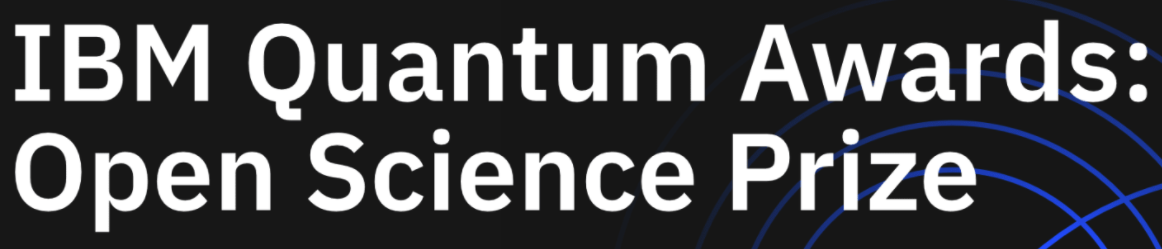

***This Notebook explains how i get The Neural-Network models. The train set is the simulation results.***

# first, we are going to define all the initial packages, and functions in order to make everything work well.

## Initial - Must run!

running all the releveant packages to make sure everything run smoothly

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -r /content/drive/MyDrive/Shared\ drive/dependencies/requirements.txt --quiet

In [3]:
! pip install 'qiskit==0.23.0'

Processing /root/.cache/pip/wheels/8f/3a/44/dcb4239f2c3b1990d89c1c931e11d302d8d8a6cd650cb8b79b/qiskit-0.23.0-cp37-none-any.whl
  Using cached https://files.pythonhosted.org/packages/06/c2/baad998e3e462266bc9c10b9ad8fe9e692b39f5774f6c77e484c1dfdc91e/qiskit_ibmq_provider-0.11.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/30/0f/ae104c53cc0cf84680dcc19ea329ab383620dce7a3db5c8ff54063e3fa95/qiskit_aqua-0.8.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/9f/c9/28cbe3ada1f1417fcc02797f51ca33810f8eea9d8537bbca7283bde77888/qiskit_aer-0.7.0-cp37-cp37m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a8/6a/64cac46d5ef10703ee59b07f6de45e124118c763ad5e067b3addcbb867e4/qiskit_terra-0.16.0-cp37-cp37m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a0/7f/ea6794cb029d235317e793483197fb562e0b344a3e4c572f7c033c6635dc/qiskit_ignis-0.5.0-py3-none-any.whl
  Found existing installation: qiskit-

In [4]:
!pip install pydash

In [5]:
# Qiskit module
from qiskit import QuantumCircuit
import qiskit.circuit.library as circuit_library
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit

# Qiskit tools for noisy simulation
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.utils import insert_noise

# Qiskit tools for running and monitoring jobs
from qiskit import execute
from qiskit.tools.monitor import job_monitor

# Other imports
import numpy as np

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Me importing a NN package - TensorFlow 2 and another important classes for the NN i'll be doing
import tensorflow
import random
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.python.ops import math_ops
from tqdm import tqdm_notebook
from keras import backend as K
import tensorflow as tf

## IBM account

we used the university account.

In [6]:
# Load IBMQ Account data
from qiskit import IBMQ
#IBMQ.delete_account()
IBMQ.save_account('6b667b93838abce50a0b809f6aa90c5952e88eb0631098a08695a4e7ce8bc726fe3b0b5cfe857730c9739fcedb4f982b24d513474ee61eab931b16b7915f59a8')
IBMQ.load_account()

# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-research', group='bar-ilan-uni-1', project='main')
backend = provider.get_backend('ibmq_casablanca')
backend_new = QasmSimulator.from_backend(backend)
properties = backend_new.properties()

configrc.store_credentials:WARNING:2021-04-12 18:39:41,923: Credentials already present. Set overwrite=True to overwrite.


## function from IBM

here i took all the defined function that were in the original challenge notebook.

In [7]:
def compute_stabilizer_group(circuit):
    """Compute the stabilizer group for stabilizer circuit."""
    state = qi.Statevector.from_instruction(circuit)
    labels = []
    for i in qi.pauli_basis(state.num_qubits):
        val = round(qi.state_fidelity(i.to_matrix()[0], state, validate=False))
        if val != 0:
            label = i.to_labels()[0]
            if val == 1:
                label = '+' + label
            else:
                label = '-' + label
            labels.append(label)
    return labels

In [8]:
def stabilizer_coeff_pauli(stabilizer):
    """Return the 1 or -1 coeff and Pauli label."""
    coeff = 1
    pauli = coeff
    if stabilizer[0] == '-':
        coeff = -1
    if stabilizer[0] in ['+', '-']:
        pauli = stabilizer[1:]
    else:
        pauli = stabilizer
    return coeff, pauli

In [9]:
def stabilizer_measure_circuit(stabilizer, initial_circuit=None):
    """Return a stabilizer measurement circuits.
    
    Args:
        stabilizer (str): a stabilizer string
        initial_circuit (QuantumCircuit): Optional, the initial circuit.
    
    Returns:
        QuantumCircuit: the circuit with stabilizer measurements.
    """
    _, pauli = stabilizer_coeff_pauli(stabilizer)
    if initial_circuit is None:
        circ = QuantumCircuit(len(pauli))
    else:
        circ = initial_circuit.copy()
    for i, s in enumerate(reversed(pauli)):
        if s == 'X':
            circ.h(i)
        if s == 'Y':
            circ.sdg(i)
            circ.h(i)
    circ.measure_all()
    return circ

In [10]:
def stabilizer_expvals(result, stabilizers, meas_mitigator=None):
    """Compute expectation values from stabilizer measurement results."""

    ### YOUR CODE GOES HERE -- START

    expvals = []
    stddevs = []
    for i, stab in enumerate(stabilizers):
        expval, stddev = mit.expectation_value(
            result.get_counts(i),
            diagonal=stabilizer_measure_diagonal(stab),
            meas_mitigator=meas_mitigator)

        expvals.append(expval)
        stddevs.append(stddev)
    return np.array(expvals), np.array(stddevs)

In [11]:
def stabilizer_measure_diagonal(stabilizer):
    """Return the diagonal vector for a stabilizer measurement.
    
    Args:
        stabilizer (str): a stabilizer string
    
    Returns:
        np.ndarray: the diagonal for measurement in the stabilizer basis.
    """
    coeff, pauli = stabilizer_coeff_pauli(stabilizer)
    diag = np.array([1])
    for s in reversed(pauli):
        if s == 'I':
            tmp = np.array([1, 1])
        else:
            tmp = np.array([1, -1])
        diag = np.kron(tmp, diag)
    return coeff * diag

In [12]:
def stabilizer_fidelity(expvals, stddevs=None):
    """Compute stabilizer state fidelity from stabilizer expvals."""
    mean = np.mean(expvals)
    if stddevs is None:
        return mean
    stddev = np.sqrt(np.sum(stddevs ** 2))
    return mean, stddev

## Functions I made for the NN data modification

here i made all kinds of function that deals with the data types (for example, taking a qiskit result get counts and change it into a normalized numpy array histogram for our fully-connected NN).

In [13]:
def stabilizer_expvals_without_counts(result, stabilizers):
    """Compute expectation values from stabilizer measurement results."""

    ### YOUR CODE GOES HERE -- START

    expvals = []
    stddevs = []
    for i, stab in enumerate(stabilizers):
        expval, stddev = mit.expectation_value(
            result[i],
            diagonal=stabilizer_measure_diagonal(stab))

        expvals.append(expval)
        stddevs.append(stddev)

    return np.array(expvals), np.array(stddevs)

    ### YOUR CODE GOES HERE -- END

In [14]:
def dict_to_hist(reps, result_backend):
  '''
  the function takes the measurement Results of IBM, and returns the full
  histogram of the data for NN 
  '''
  template_labels = [bin(x)[2:].rjust(num_qubits, '0') for x in range(2**num_qubits)]
  template = {el:0 for el in template_labels}
  expval = []

  for i in range(reps):
      temp_list = []
      for j in range(len(result_backend[i].get_counts())):
          template = {el:0 for el in template_labels}
          for k in result_backend[i].get_counts(j).keys():
              template[k] = result_backend[i].get_counts(j)[k]
          temp_list.append(template)
      expval.append(temp_list)
  
  return expval

In [15]:
def hist_for_NN(expval,reps,labels):
    x_full = []
    for i in range(reps):
      x = []
      for j in range(len(labels)):
          x.append(np.array(list(expval[i][j].values()))/np.array(list(expval[i][j].values())).sum())
      x_full.append(x)
    return x_full

In [16]:
def hist_for_NN_Data(expval,reps,labels):
    x = []
    for i in range(reps):
      for j in range(len(labels)):
          x.append(np.array(list(expval[i][j].values()))/np.array(list(expval[i][j].values())).sum())
    return x

In [17]:
def Data_For_NN(adjmat ,reps , num_qubits, shots, labels):
    '''
    this function generates a new results for the NN model function, and returns it's histograms. 
    '''
    ################################# first let's generate a different data- by using the same method as IBM did 
    

    # the graph state can be created using Qiskit's circuit library
    state_circuit = create_graph_state()
    state_circuit.draw()
    
    stabilizers = compute_stabilizer_group(state_circuit)
    
    stabilizer_circuits = [stabilizer_measure_circuit(stab, state_circuit)
                       for stab in stabilizers]
       
    meas_cal_circuits, metadata = mit.expval_meas_mitigator_circuits(num_qubits, method='CTMP', labels=labels)

    il = [0,1,2,3,4,5,6]

    all_jobs = []
    all_jobs_mit = []

    for ii in tqdm_notebook(range(reps)):
        # Run QPT on backend
        job_backend = execute(stabilizer_circuits, backend_new, shots=shots, initial_layout=il)
        job_mit_backend = execute(meas_cal_circuits, backend_new, shots=shots, initial_layout=il)
        all_jobs.append(job_backend)
        all_jobs_mit.append(job_mit_backend)
    
    result_backend = []
    result_mit_backend = []
    
    for job in all_jobs:
        # Retrieve results (this may take a while depending on the queue)
        result_backend.append(job.result())
    
    for job in all_jobs_mit:
        result_mit_backend.append(job.result())  

    # the correct result from the stabilizer
    
    ideal_simulator = QasmSimulator()

    all_jobs_correct = []
    for ii in range(reps):
            # Run QPT on backend
            job_backend_correct = execute(meas_cal_circuits, ideal_simulator, shots=shots, initial_layout=il)
            all_jobs_correct.append(job_backend_correct)

    result_backend_correct = []
    
    for job in all_jobs_correct:
        # Retrieve results (this may take a while depending on the queue)
        result_backend_correct.append(job.result())     
        
    # make a template so all the data will be the same size for NN

    expval_correct = dict_to_hist(reps, result_backend_correct)
    expval = dict_to_hist(reps, result_backend)
    expval_mit = dict_to_hist(reps, result_mit_backend)

        ###################################################################
    return expval, expval_mit, expval_correct, result_backend, result_mit_backend

In [18]:
def create_graph_state():
    
    ### YOUR CODE GOES HERE -- START
    
    graph_state_circuit = circuit_library.GraphState(adjmat)
    
    ### YOUR CODE GOES HERE -- END
    
    return graph_state_circuit

## Constants for the NN

In [19]:
adjmat = [
    [0, 1, 0, 0, 0, 0, 0], 
    [1, 0, 1, 1, 0, 0, 0], 
    [0, 1, 0, 0, 0, 0, 0], 
    [0, 1, 0, 0, 0, 1, 0], 
    [0, 0, 0, 0, 0, 1, 0], 
    [0, 0, 0, 1, 1, 0, 1], 
    [0, 0, 0, 0, 0, 1, 0]]

In [20]:
## Compute the stabilizers for this graph state
state_circuit = create_graph_state()
#generators = qi.Clifford(state_circuit).stabilizer.pauli.to_labels()
stabilizers = compute_stabilizer_group(state_circuit)

In [21]:
reps = 1

In [22]:
num_qubits = 7

In [23]:
shots = 8192

In [24]:
'''
labels = ['0000000', '0000011', '0000101', 
      '0001001', '0001010', '0001100', 
      '0010001', '0010010', '0010100', '0011000', 
      '0100001', '0100010', '0100100', '0101000', '0110000', 
      '1000001', '1000010', '1000100', '1001000', '1010000', '1100000', 
      '1111111']
'''

labels = [bin(x)[2:].rjust(num_qubits, '0') for x in range(2**num_qubits)]


In [25]:
meas_cal_circuits, metadata  = mit.expval_meas_mitigator_circuits(num_qubits, method='CTMP', labels=labels)

## graph Function for the NN
a ln(MSE) in each epoch

In [28]:
def Error_MSE_Graph(history):
  import matplotlib
  matplotlib.rcParams.update({'font.size': 30})
  plt.figure(figsize=[20,10])
  plt.semilogy(history.history['loss'])
  plt.ylabel('MSE')
  plt.xlabel('# epoches')

#The Fully-Connected Neural Network

***We did a NN model where we set the weight matrix be non-negative and allow Bias.***

## The Data for The Neural-Network

before we create the models, we generated the data almost as the constants as there are in the original notebook, yet the difference is the amount of labels (we generated for the full 128 states) , but we decrease the amount of repititions to **only 1**

here we get the final results, as:


*   expval - an histogram of result_backend for NN
*   expval_mit - an histogram of result_mit_backend for NN
*   expval_correct - an histogram of an ideal quantum computer without noise for NN

the result_backend and result_mit_backend are kept in order to evalute the fidelity results by the end.





In [27]:
[expval, expval_mit, expval_correct, result_backend, result_mit_backend] = Data_For_NN(adjmat ,reps , num_qubits, shots, labels)

In [30]:
X = hist_for_NN(expval_mit,reps,labels)
Y = hist_for_NN(expval_correct,reps,labels)

## The NN model


here we have the model itself

In [31]:
model = Sequential([
  Dense(2**num_qubits, activation='linear', use_bias=True,kernel_constraint=tf.keras.constraints.NonNeg(), input_shape=(128,)),
])
opt = keras.optimizers.SGD(learning_rate=0.4, momentum=0.999)

model.compile(
  optimizer=opt,
  loss = "mse",
  metrics=['mse'],
)

here is the fitting/learning process. by the end of the process, you can see how the MSE goes down as the amount of epoches increases.

in case you would want to run it, here's our result.

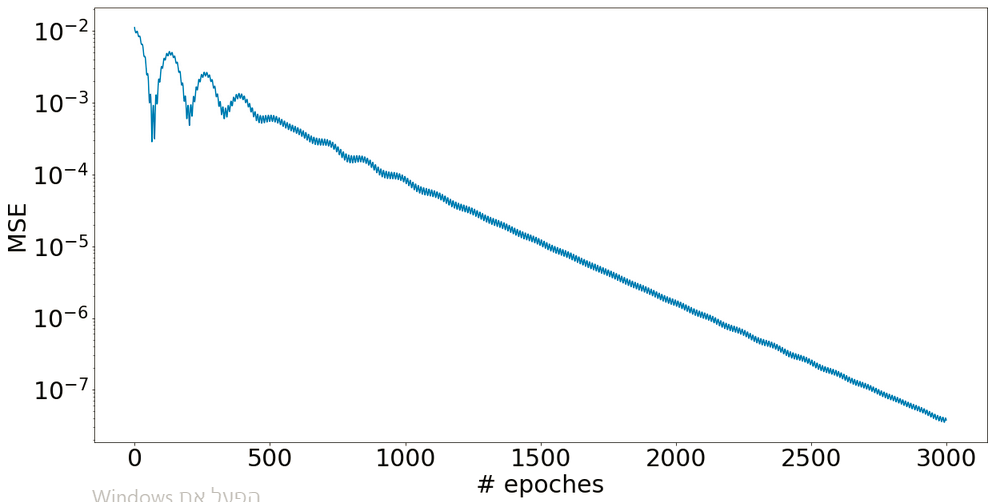

Streaming output truncated to the last 5000 lines.
Epoch 501/3000
4/4 [==============================] - 0s 2ms/step - loss: 5.4641e-04 - mse: 5.4641e-04
Epoch 502/3000
4/4 [==============================] - 0s 3ms/step - loss: 6.0597e-04 - mse: 6.0597e-04
Epoch 503/3000
4/4 [==============================] - 0s 4ms/step - loss: 6.2027e-04 - mse: 6.2027e-04
Epoch 504/3000
4/4 [==============================] - 0s 3ms/step - loss: 6.4142e-04 - mse: 6.4142e-04
Epoch 505/3000
4/4 [==============================] - 0s 5ms/step - loss: 6.6413e-04 - mse: 6.6413e-04
Epoch 506/3000
4/4 [==============================] - 0s 5ms/step - loss: 6.6879e-04 - mse: 6.6879e-04
Epoch 507/3000
4/4 [==============================] - 0s 3ms/step - loss: 6.5847e-04 - mse: 6.5847e-04
Epoch 508/3000
4/4 [==============================] - 0s 5ms/step - loss: 5.9003e-04 - mse: 5.9003e-04
Epoch 509/3000
4/4 [==============================] - 0s 3ms/step - loss: 5.5130e-04 - mse: 5.5130e-04
Epoch 510/3000
4/4 [==

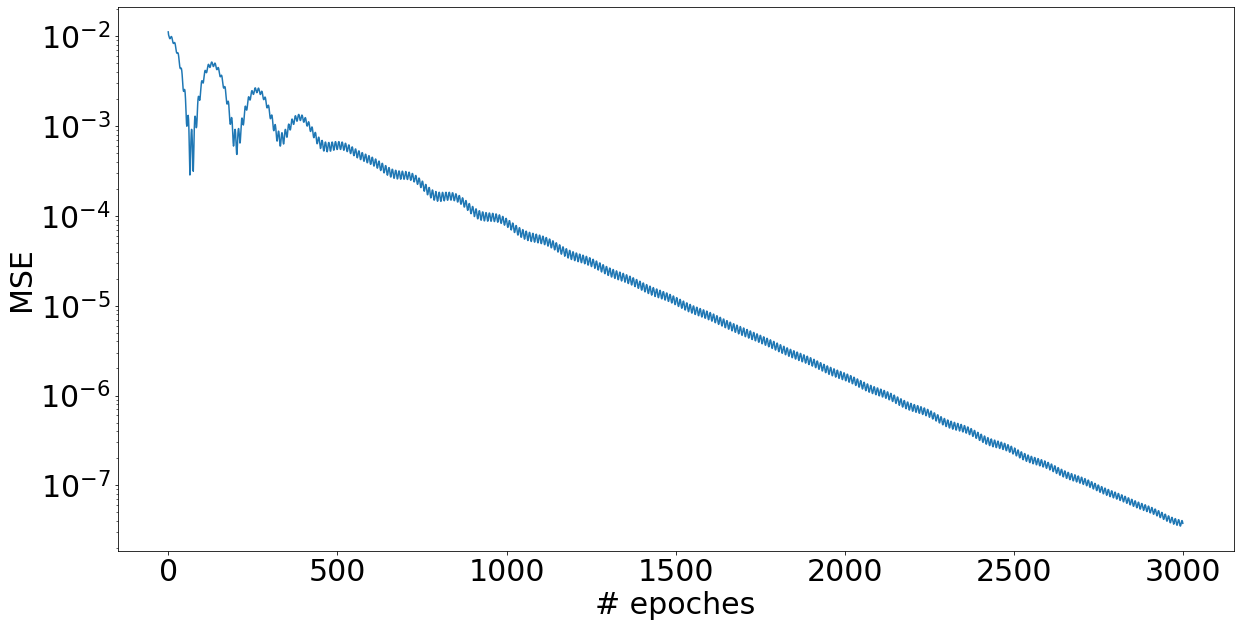

In [32]:
history = model.fit(
 np.array(X[0]),
  np.array(Y[0]),
  epochs=3000
)

Error_MSE_Graph(history)

the final fidelity - with threshold of 0.01, and without threshold.

### With Threshold

In [32]:
template_labels = [bin(x)[2:].rjust(num_qubits, '0') for x in range(2**num_qubits)]

test_list = hist_for_NN(expval,reps,template_labels)

F_mit_NN = []
for k in range(reps):
  F_mit_NN.append(model.predict(np.array(test_list)[k])*shots)
for k in range(reps):
  F_mit_NN[k][F_mit_NN[k] < 0.01*shots] = 0
temp_list_full = []

F_nomit_backend = []
F_mit_backend = []

temp_list = []

for k in range(reps):
  temp_list_l = []
  for i in range(2**num_qubits):
    template = {el:0 for el in template_labels}
    for j in range(F_mit_NN[k][i].shape[0]):
        template[template_labels[j]] = F_mit_NN[k][i][j] #
    temp_list_l.append(template)    
  temp_list.append(temp_list_l) 

F_mit_backend_NN_threshhold = []

for ii in range(reps):
    F_mit_NN_exp_val, F_mit_NN_std_val = stabilizer_expvals_without_counts(temp_list[ii], stabilizers)
    F_mit_backend_NN_threshhold.append(stabilizer_fidelity(F_mit_NN_exp_val, F_mit_NN_std_val)[0])

for ii in range(reps):
    # Unmitigated Expectation Values
    expvals_nomit_b, stddevs_nomit_b = stabilizer_expvals(
        result_backend[ii], stabilizers)
    F_nomit_backend.append(stabilizer_fidelity(expvals_nomit_b, stddevs_nomit_b)[0])
    # Fit measurement error mitigators
    mitigator_backend = mit.ExpvalMeasMitigatorFitter(result_mit_backend[ii], metadata).fit()
    # Measurement error mitigated expectation values
    expvals_mit_b, stddevs_mit_b = stabilizer_expvals(
        result_backend[ii], stabilizers, meas_mitigator=mitigator_backend)
    F_mit_backend.append(stabilizer_fidelity(expvals_mit_b, stddevs_mit_b)[0])

print('\nNN fully-C\
onnected error mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_mit_backend_NN_threshhold), np.std(F_mit_backend_NN_threshhold)))

print('\nNo mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_nomit_backend), np.std(F_nomit_backend)))

print('\nCTMP error mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_mit_backend), np.std(F_mit_backend)))



NN fully-Connected error mitigation
F(ibmq_casablanca) = 1.000 ± 0.000

No mitigation
F(ibmq_casablanca) = 0.745 ± 0.000

CTMP error mitigation
F(ibmq_casablanca) = 0.907 ± 0.000


### Without Threshold

In [33]:
template_labels = [bin(x)[2:].rjust(num_qubits, '0') for x in range(2**num_qubits)]

test_list = hist_for_NN(expval,reps,labels)

F_mit_backend_NN = []
F_mit_NN = model.predict(tf.constant(test_list)[0])*shots
F_mit_NN[F_mit_NN < 0] = 0
temp_list_full = []

F_nomit_backend = []
F_mit_backend = []

temp_list = []
temp_list = []


for k in range(reps):
  temp_list_l = []
  for i in range(len(labels)):
    template = {el:0 for el in template_labels}
    for j in range(F_mit_NN.shape[0]):
        template[template_labels[j]] = F_mit_NN[i][j] #
    temp_list_l.append(template)    
  temp_list.append(temp_list_l) 
      
for ii in range(reps):
    F_mit_NN_exp_val, F_mit_NN_std_val = stabilizer_expvals_without_counts(temp_list[ii], stabilizers)
    F_mit_backend_NN.append(stabilizer_fidelity(F_mit_NN_exp_val, F_mit_NN_std_val)[0])

for ii in range(reps):
    # Unmitigated Expectation Values
    expvals_nomit_b, stddevs_nomit_b = stabilizer_expvals(
        result_backend[ii], stabilizers)
    F_nomit_backend.append(stabilizer_fidelity(expvals_nomit_b, stddevs_nomit_b)[0])
    # Fit measurement error mitigators
    mitigator_backend = mit.ExpvalMeasMitigatorFitter(result_mit_backend[ii], metadata).fit()
    # Measurement error mitigated expectation values
    expvals_mit_b, stddevs_mit_b = stabilizer_expvals(
        result_backend[ii], stabilizers, meas_mitigator=mitigator_backend)
    F_mit_backend.append(stabilizer_fidelity(expvals_mit_b, stddevs_mit_b)[0])

print('\nNN fully-C\
onnected error mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_mit_backend_NN), np.std(F_mit_backend_NN)))

print('\nNo mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_nomit_backend), np.std(F_nomit_backend)))

print('\nCTMP error mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_mit_backend), np.std(F_mit_backend)))



NN fully-Connected error mitigation
F(ibmq_casablanca) = 0.905 ± 0.000

No mitigation
F(ibmq_casablanca) = 0.745 ± 0.000

CTMP error mitigation
F(ibmq_casablanca) = 0.908 ± 0.000
